# Exercises 25

##problem 1

Put together the stationary heat equation (poisson equation) with the explicit Euler method to be able to solve the *time dependent heat equation*.

Given a rectangular domain $\Omega \subset \mathbb{R}^2 $ and a time dependent function 
$u(x,t) , x \in \Omega , t \in \mathbb{R}^{+}$. Then the time dependent heat equation is
$$\frac{\partial u}{\partial t} - \alpha \triangle u = 0  \text{ in } \Omega $$
where $\alpha \in \mathbb{R}$ is a constant . Given dirichlet boundary conditions 
$$u = R , \text{ on } \partial \Omega$$
with a function $R: \partial \Omega \mapsto C(\partial \Omega)$. At time $t=0$ let
$$u(x,0) = f(x), \forall x \in \Omega.$$
with a arbitrary, but fixed initial function $f: \mathbb{R} \mapsto \mathbb{R}$.

*Remark:* Try to write the code with a sparse matrix (but with small number of points per axis up to 50 a dense matrix is also fine)

In [10]:
:extension NoMonomorphismRestriction
:ext BangPatterns
import Numeric.Container
import Numeric.LinearAlgebra.Algorithms
import Numeric.LinearAlgebra.Util
import Numeric.LinearAlgebra.HMatrix
import Graphics.Rendering.Plot
import Numeric.LinearAlgebra.Data

idx2grid :: Int -> Int -> (Int, Int)
idx2grid n i = (i `mod` n, i `div` n)

idxf :: Int -> (Int, Int) -> Double
idxf n (i, j)
    | i == j                        = 4
    | xi == xj && abs(yi - yj) == 1 = -1
    | yi == yj && abs(xi - xj) == 1 = -1
    | otherwise                     = 0
    where (xi, yi) = idx2grid n i
          (xj, yj) = idx2grid n j

al = 0.5
n = 70

poisson :: Int -> Double -> ([(Double, Double)],GMatrix,  Vector Double, Double)
poisson n al = (mesh, a, f, ht) 
      where
          -- coordinates
          x = linspace (n+1) (0,1::Double)
          h = x @> 1
          -- inner points
          xInner = subVector 1 (n-1) x
          mesh = [ (xj, yj) | xj <- toList xInner , yj <- toList xInner ]
          -- laplace matrix (now sparse)
          a = mkSparse [ ((i,j),-idxf (n-1) (i,j)) | 
              i<- [0,1..(n-1)^2-1::Int] , 
              j <- [0,1..(n-1)^2-1], idxf (n-1) (i,j) /= 0  ]
          --a = buildMatrix ((n-1)^2) ((n-1)^2) (idxf (n-1)) :: Matrix Double
          -- right hand side
          f = fromList $ map (\(x, y) -> (h^2)*x*(y^4)) mesh
          -- For stability: calculate time-step:
          ht = 1/(2*al )/100

(me,a,f,ht) = poisson n al

initialState :: Int  -> Matrix Double
initialState n = buildMatrix (n-1) (n-1) fu
    where
        fu (i,j)
            | (i - half)^2 + (j - half)^2 <= 4*radius^2 && (i - half)^2+(j - half)^2 >=radius^2 =  1
            | otherwise = 0
            where
                half = div n 2
                radius = div n 5
                                

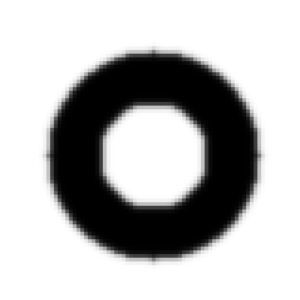

In [11]:
iter n f !x 
    | n==0 = x
    | otherwise = iter (n-1) f (f x)


loes = iter 80 (\x -> x + (ht * al) `scale` (a !#> x + f) ) (flatten $ initialState n)
setPlots 1 1 >> withPlot (1, 1) (setDataset $ reshape (n-1) $loes )

In [3]:
-- write out matrices to visualize with python
(xl,yl) = unzip me
xmat = reshape (n-1) (fromList xl)
ymat = reshape (n-1) (fromList yl)
-- create x and y matrix
saveMatrix "xmat.txt" "%f" xmat
saveMatrix "ymat.txt" "%f" ymat
saveMatrix "zmat.txt" "%f" (reshape (n-1) loes) 
-- ../vis.py -x xmat.txt -y ymat.txt -z zmat.txt -b "" -t image



## problem 2

Lets look into a bit image transformation. Take the greyscale image `"images/Grayscale_8bits_palette.bmp"` and make a *edge detection* on it. *edge detection* works through applying a convolution of the (here grayscale values in every pixel) with the convolution-matrix  

 $$\left(\begin{array}
-- 1 & - 1 &- 1 \\
 - 1  &  8&- 1 \\
     - 1 &- 1 &- 1 \end{array}\right)$$ 
     
You can use repa stencils for this. Reading the image can also be done with 

```haskell
import Data.Array.Repa.IO.BMP (readImageFromBMP)     
```

You can either write the image again (and the show it with an imageviewer) or you can use
the simple plot-interface 

```haskell
import Graphics.Rendering.Plot
```
together with
```haskell
import Data.Packed.Repa (repaToMatrix)
```

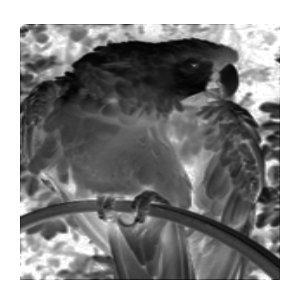

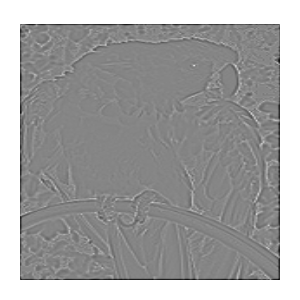

In [32]:
{-# LANGUAGE QuasiQuotes #-}
{-# LANGUAGE FlexibleContexts#-}

import Data.Array.Repa as R hiding ((++))
import Data.Array.Repa.Stencil
import Data.Array.Repa.Stencil.Dim2
import Data.Packed.Repa (repaToMatrix)

import Data.Array.Repa.IO.BMP (readImageFromBMP, writeImageToBMP)
import Data.Array.Repa.Algorithms.Pixel (doubleLuminanceOfRGB8, rgb8OfGreyDouble)

loadImage :: FilePath -> IO (Array U DIM2 Double)
loadImage file = do
  loaded <- readImageFromBMP file 
  case loaded of
    Left err -> error $ show err
    Right img -> computeP $ R.map doubleLuminanceOfRGB8 img

saveImage :: FilePath -> Array U DIM2 Double -> IO ()
saveImage file img = do
  !m <- foldAllP max 0 img
  !img' <- computeP $ R.map (rgb8OfGreyDouble . (/ m)) img
  writeImageToBMP file img'


edgeStencil :: Stencil DIM2 Double
edgeStencil = [stencil2|  -1 -1  -1
                          -1  8  -1
                          -1 -1  -1 |]
                             
                                                    

img <- loadImage "../images/parrot.bmp"
imgedge = computeS $ delay $ mapStencil2 (BoundConst 0) edgeStencil img
setPlots 1 1 >> withPlot (1, 1) (setDataset $ repaToMatrix $ copyS img )
setPlots 1 1 >> withPlot (1, 1) (setDataset $ repaToMatrix imgedge )


-- saveImage "../images/Grayscale_8bits_palette_edge.bmp" imgedge


## problem 3

Remember the *Jacobi* method to solve an system of linear equations. Rewrite the Jacobi method that it works with *stencils* (so the forward operator is given as a stencil). 

For this you also the need the componentwise version of the Jacobi method, which is given by

$$x_i^{( k + 1 )} = \frac{1}{a_{ii}} ( b_i - \sum_{j \neq i} a_{ij} x_j^{( k )} ) , i = 1 , 2 , … , n $$

where $a_{ij}$ are the component of the matrix $A$, $b$ is the right hand side and the $x$ starts from an initial guess. 

You can work along the lines of the example of the cg-method from the lecture (create a stencil, a right hand side and a jacobi function which makes the parallel computation)

For a testcase use the appropriate stencil and right hand side for the 2d poisson equation.


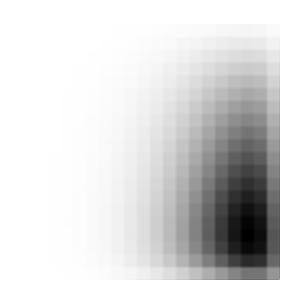

In [15]:
{-# LANGUAGE QuasiQuotes #-}
{-# LANGUAGE BangPatterns #-}
{-# LANGUAGE FlexibleContexts #-}
import Data.Array.Repa as R hiding ((++))
import Data.Array.Repa.Stencil
import Data.Array.Repa.Stencil.Dim2
import Data.Packed.Repa (repaToMatrix)

poissonJStencil :: Stencil DIM2 Double
poissonJStencil = [stencil2|  0 -1  0
                              -1  0 -1
                              0 -1  0 |]


rhs :: Int -> Array U DIM2 Double 
rhs n = computeS $ fromFunction (Z:.n:.n) $ \(Z:.i:.j) -> f (toCoord i) (toCoord j)
    where h = 1 / fromIntegral n
          toCoord i = fromIntegral i*h  
          f x y = h^2*x*(y^4)

jacobi :: Double -> Stencil DIM2 Double -> Array U DIM2 Double -> [Array U DIM2 Double]
jacobi center st rhs  = iterate step zeros
    where
        step !x = computeS $ R.map (/center) (rhs -^ mapStencil2 (BoundConst 0) st x) :: Array U DIM2 Double
        zeros =  computeS $ fromFunction (extent rhs) (const 0)
        
loes = last $ take 20 $ jacobi 4 poissonJStencil (rhs 20)  


import Graphics.Rendering.Plot

setPlots 1 1 >> withPlot (1, 1) (setDataset (repaToMatrix $ copyS loes))